<a href="https://colab.research.google.com/github/anandhulk/Quora-sincere-and-insincere-questions-classification/blob/main/word2vec_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim

In [2]:
import numpy as np 
import pandas as pd 
import gensim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_csv("/content/drive/MyDrive/dataset-quora/final-cleaned-dataset.csv")
df

,0,target
0,how do Quebec nationalist see their province a...,0
1,do you have an adopted dog how would you enco...,0
2,why do velocity affect time do velocity affec...,0
3,how do Otto von Guericke use the Magdeburg hem...,0
4,can I convert montra helicon d to a mountain b...,0
...,...,...
1306117,what other technical skill do you need as a co...,0
1306118,do MS in ECE have good job prospect in USA or ...,0
1306119,be foam insulation toxic,0
1306120,how can one start a research project base on b...,0


In [6]:
df = df.dropna()
questions=df["0"]

In [7]:
questions=questions.apply(gensim.utils.simple_preprocess)

In [8]:
questions

0          [how, do, quebec, nationalist, see, their, pro...
1          [do, you, have, an, adopted, dog, how, would, ...
2          [why, do, velocity, affect, time, do, velocity...
3          [how, do, otto, von, guericke, use, the, magde...
4          [can, convert, montra, helicon, to, mountain, ...
                                 ...                        
1306117    [what, other, technical, skill, do, you, need,...
1306118    [do, ms, in, ece, have, good, job, prospect, i...
1306119                        [be, foam, insulation, toxic]
1306120    [how, can, one, start, research, project, base...
1306121    [who, win, in, battle, between, wolverine, and...
Name: 0, Length: 1306121, dtype: object

# **Word2vec MODEL**

In [9]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [10]:
model.build_vocab(questions, progress_per=1000)

In [11]:
model.train(questions, total_examples=model.corpus_count, epochs=model.epochs)

(56496237, 79590230)

In [12]:
#model.save("quora-word2vec.model")

In [13]:
model.wv.most_similar("india")

[('nepal', 0.8029589653015137),
 ('bangladesh', 0.7762115597724915),
 ('kerala', 0.7217837572097778),
 ('pakistan', 0.7024464011192322),
 ('indian', 0.7010756134986877),
 ('malaysia', 0.6934955716133118),
 ('karnataka', 0.6854183673858643),
 ('punjab', 0.6778672337532043),
 ('gujarat', 0.6754388809204102),
 ('tamilnadu', 0.6520277261734009)]

In [14]:
model.wv.similarity(w1="prawn",w2="pawn")

0.24689585

In [15]:
vocab_size=len(model.wv.key_to_index)
vocab_size

77131

In [16]:
print(model.wv.key_to_index.get("cat",None))

395


# **TEXT VECTORIZATION**

In [17]:
def vectorize(data,vocab):
    res=[]
    count=len(data)
    for row in data:
        row_res=[]
        for word in row:
            index=model.wv.key_to_index.get(word,None)
            if(index!=None):
                row_res.append(index)
        res.append(row_res)
        
        #counter
        count=count-1
        if(count%100000==0):
            print("remaining no of rows:",count)
        #counter
        
    return res

In [18]:
input_length = 300
X_pad = pad_sequences(
    sequences=vectorize(questions, vocab=model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

remaining no of rows: 1300000
remaining no of rows: 1200000
remaining no of rows: 1100000
remaining no of rows: 1000000
remaining no of rows: 900000
remaining no of rows: 800000
remaining no of rows: 700000
remaining no of rows: 600000
remaining no of rows: 500000
remaining no of rows: 400000
remaining no of rows: 300000
remaining no of rows: 200000
remaining no of rows: 100000
remaining no of rows: 0
Transform sentences to sequences... (done)


# **Spltting the Data set**

In [19]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X_pad,df["target"],test_size=0.2,random_state=42)

In [20]:
embedding_matrix=model.wv.vectors

# **MODEL**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Dropout,Embedding,GRU

In [26]:
lstm_model=Sequential([
    Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])

lstm_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

In [27]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          7713100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         84480     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dropout_3 (Dropout)         (None, 10)               

In [ ]:
lstm_model.fit(x_train,y_train,epochs=5)

In [ ]:
lstm_model.evaluate(x_test,y_test)

8164/8164 [==============================] - 172s 21ms/step - loss: 0.1048 - accuracy: 0.9582


[0.10477418452501297, 0.9582160711288452]

*Saving the model for future use*

In [50]:
#lstm_model.save("w2v+LSTM_model")

In [45]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
y_pred=lstm_model.predict(x_test)

In [ ]:
y_p=[]
for i in y_pred:
    if(i>=0.5):
        y_p.append(1)
    else:
        y_p.append(0)

# **CONFUSION MATRIX**

In [ ]:
confusion=confusion_matrix(y_test,y_p)
confusion

array([[241564,   3569],
       [  7346,   8746]])

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

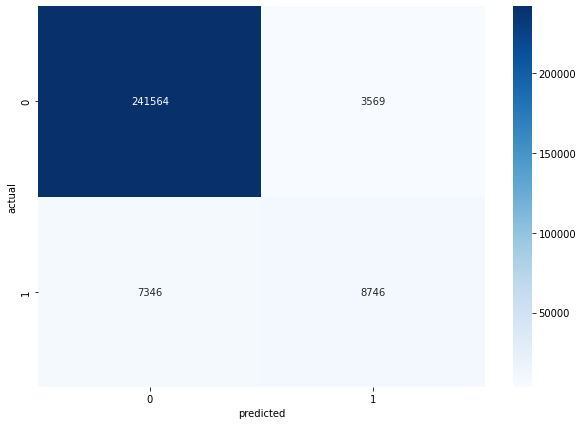

In [ ]:

plt.figure(figsize = (10,7))
sns.heatmap(confusion, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

# **CLASSIFICATION REPORT - PRECISION, RECALL, F1 SCORE**


In [ ]:
print("     Classification report of Word2vec + LSTM model\n")
print(classification_report(y_test,y_p))

     Classification report of Word2vec + LSTM model

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    245133
           1       0.71      0.54      0.62     16092

    accuracy                           0.96    261225
   macro avg       0.84      0.76      0.80    261225
weighted avg       0.95      0.96      0.96    261225



**F1 score is not very impressive**

# **GRU MODEL**

In [29]:
gru_model=Sequential([
    Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False),
    Bidirectional(GRU(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(32)),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])

gru_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          7713100   
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 128)         63744     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 300, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dropout_5 (Dropout)         (None, 10)               

In [30]:
gru_model.fit(x_train,y_train,epochs=3)

Epoch 1/3
32653/32653 [==============================] - 1086s 33ms/step - loss: 0.1348 - accuracy: 0.9380
Epoch 2/3
32653/32653 [==============================] - 1080s 33ms/step - loss: 0.1265 - accuracy: 0.9468
Epoch 3/3
32653/32653 [==============================] - 1082s 33ms/step - loss: 0.1249 - accuracy: 0.9508


In [31]:
gru_model.evaluate(x_test,y_test)

8164/8164 [==============================] - 147s 18ms/step - loss: 0.1156 - accuracy: 0.9556


[0.11560391634702682, 0.9555976390838623]

In [49]:
#gru_model.save('/content/drive/MyDrive/dataset-quora/word2vec_grumodel')

# **MODEL EVALUATION**

In [ ]:
y_gru=gru_model.predict(x_test)

In [41]:
y_pred_gru=[]

for i in y_gru:
    if(i>=0.5):
        y_pred_gru.append(1)
    else:
        y_pred_gru.append(0)

#  **CONFUSION MATRIX**

In [46]:
confusion_gru=confusion_matrix(y_test,y_pred_gru)
confusion_gru

array([[242270,   2863],
       [  8736,   7356]])

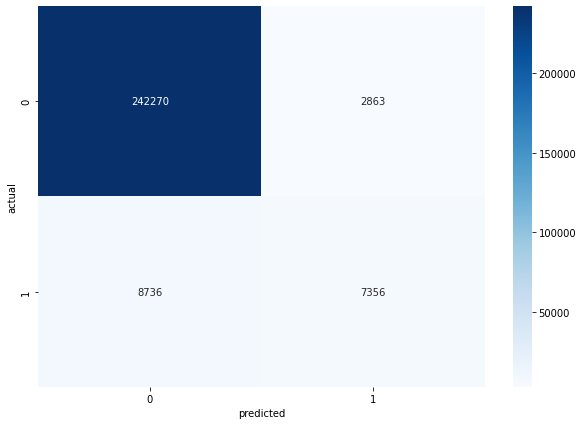

In [47]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_gru, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

# **CLASSIFICATION REPORT**

In [48]:
print("     Classification report of Word2vec + LSTM model\n")
print(classification_report(y_test,y_pred_gru))

     Classification report of Word2vec + LSTM model

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    245133
           1       0.72      0.46      0.56     16092

    accuracy                           0.96    261225
   macro avg       0.84      0.72      0.77    261225
weighted avg       0.95      0.96      0.95    261225

